# Q-learning toy problem with R-learning

Q-learning in grid-worlds with binomial rewards and reward smoothing.

Author: M. Kaisers *kaisers@cwi.nl*

## Settings

In [184]:
n_steps = 10000
STEPS_PER_TRAINING = int(n_steps/50)
BATCHES_PER_TRAINING = 4

EVALUATION_EPISODES = 10
TRAINING_EPISODE_TIMEOUT = 100
EVALUATION_EPISODE_TIMEOUT = 50

GAMMA = 0.99
R_MAX = 1 # Maximal reward
G_MAX = 1/(1-GAMMA) * R_MAX # Theoretical maximal discounted return

Q_INIT = 0 # Zero initialisation
# Q_INIT = G_MAX # Optimistic initialisation

BIAS = [0, 0.2]

# Learning rate as a function of visits to (s, a)
ALPHA_SCHEDULE = lambda n: 0.1 # Constant alpha, resulting in exponential average
# ALPHA_SCHEDULE = lambda n: 1/n # Simple average
# ALPHA_SCHEDULE = lambda n: 0.95*5/(n+5)+0.05 # Gradual averaging to exponential average

EXPLORATION_TYPE = 'softmax'
# EXPLORATION_TYPE = 'epsilon-greedy'
# EXPLORATION_TYPE = 'UCB-like'
BETA = 10 # softmax exploration factor (smaller more uniform exploration)
UCB_EXPLORATION_FACTOR = 10.0

# BINOMIAL_REWARDS = True
BINOMIAL_REWARDS = False
EXPONENTIAL_R_SMOOTHING = True
STEP_REWARD, BOUNCE_REWARD = -0.01,  -1

CUSTOM_GRID_WORLD = True # if false, uses Daniel W's gridworld
GOAL_EXPECTATIONS = (0.4, 0.6)
MAX_RETURN = max(GOAL_EXPECTATIONS) + 10 * STEP_REWARD

# Debugging
# GAMMA = 1.0
# STEP_REWARD, BOUNCE_REWARD = 0, 0

# Pre-compile a file signature from settings
env_string = "GW" if CUSTOM_GRID_WORLD else "DW"
FILE_SIG = f"Results_env={env_string}, ex={EXPLORATION_TYPE}, n={n_steps}, RS={EXPONENTIAL_R_SMOOTHING}, nB={BATCHES_PER_TRAINING}"

## Libraries

In [172]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from typing import Final
from collections import defaultdict

In [173]:
# percentile based on
# http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html

# adapted according to empirical on
# https://github.com/LizaLebedeva/bootstrap-experiments/blob/master/bootstrap_methods.ipynb

def bootstrap_empirical(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    obs_metric = func(data) # compute CI center from data directly
#     simulations = simulations - obs_metric # now move bootstrap to differences
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        percentile_upper = simulations[l_indx]
        percentile_lower = simulations[u_indx]
        empirical_lower = 2*obs_metric - percentile_lower
        empirical_upper = 2*obs_metric - percentile_upper
        return(empirical_lower,empirical_upper)
    return(ci)

# def bootstrap_percentile(data, n=1000, func=np.mean):
#     """
#     Generate `n` bootstrap samples, evaluating `func`
#     at each resampling. `bootstrap` returns a function,
#     which can be called to obtain confidence intervals
#     of interest.
#     """
#     simulations = list()
#     sample_size = len(data)
#     xbar_init = np.mean(data)
#     for c in range(n):
#         itersample = np.random.choice(data, size=sample_size, replace=True)
#         simulations.append(func(itersample))
#     simulations.sort()
#     def ci(p):
#         """
#         Return 2-sided symmetric confidence interval specified
#         by p.
#         """
#         u_pval = (1+p)/2.
#         l_pval = (1-u_pval)
#         l_indx = int(np.floor(n*l_pval))
#         u_indx = int(np.floor(n*u_pval))
#         return(simulations[l_indx],simulations[u_indx])
#     return(ci)

[(1.8099320096143252, 2.0646996371976454), (1.7899799036232267, 2.0862474497899193), (1.7506853503743685, 2.133112855052783), (1.7236520134701596, 2.150376848443598)]


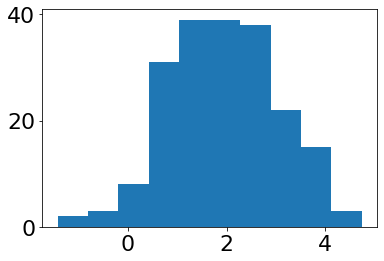

In [174]:
# Testing the empirical bootstrap
x = np.random.normal(2, 1.2, 200)
plt.hist(x)
boot = bootstrap_empirical(x)
cintervals = [boot(i) for i in (.90, .95, .99, .995)]
print(cintervals)
# boot = bootstrap_percentile(x)
# cintervals = [boot(i) for i in (.90, .95, .99, .995)]
# print(cintervals)

## Classes
Environment and learner

In [175]:
class Gridworld():
    """ Gridworld
    
    state (x, y)
    """
    ACTION_UP: Final[int] = 0
    ACTION_RIGHT: Final[int] = 1
    ACTION_DOWN: Final[int] = 2
    ACTION_LEFT: Final[int] = 3
    ACTION_DIM: Final[int] = 4
    ACTION_MAP: Final[list] = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    ACTION_STRING: Final[list] = ["Up", "Right", "Down", "Left"]
    
    def __init__(self, size=(5, 3), start=(0, 0), terminal_states={(4, 2) : 1}):
        assert len(size) == 2, "Size (x, y) incorrectly specified."
        self.size = size
        self.start = start
        self.terminal_states = terminal_states
    
    def reset(self):
        """ Returns the initial state. """
        return self.start
    
    def transition(self, s, a):
        x, y = s
        assert 0 <= a < self.ACTION_DIM, f"Invalid action {a}"
        dx, dy = self.ACTION_MAP[a]
        pns = (x+dx, y+dy)
        ns = (np.clip(x+dx, 0, self.size[0]-1), np.clip(y+dy, 0, self.size[1]-1))
        r = STEP_REWARD
        if ns != pns:
            r += BOUNCE_REWARD
        terminal = ns in self.terminal_states
        if terminal:
            if BINOMIAL_REWARDS:
                assert 0 <= self.terminal_states[ns] <= 1, f"Terminal states under binomial reward must be in range [0, 1], but was {self.terminal_states[ns]}."
                r += np.random.binomial(1, self.terminal_states[ns])
            else:
                r += self.terminal_states[ns]
        return (ns, r, terminal)
    
    def encode_value(self, Q, agg_func=max):
        board = np.zeros(self.size)
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                s = (x, y)
                if s in Q:
                    board[x][y] = agg_func(Q[s])
                else:
                    board[x][y] = np.NaN
        return board.transpose()

    def encode_board(self, s = None):
        board = np.ones(self.size)*STEP_REWARD
        for g in self.terminal_states:
            board[g[0], g[1]] = self.terminal_states[g]
        if s:
            board[s[0],s[1]] = 0.5
        return board.transpose()
    
    def print_board(self, s):
        board = self.encode_board(s)
        lines = ["|" + ''.join("%d"%abs(x) for x in y) + "|" for y in board]
        bar = "+" + "-"*(self.size[0]) + "+"
        lines.append(bar)
        lines.insert(0, bar)
        return '\n'.join(reversed(lines)).replace('0', ' ').replace('1', 'x').replace('2', 'T')

    def plot_board(self, s=None):
        plt.figure()
        board = self.encode_board(s)
        plt.imshow(board, origin='lower')
        plt.axis('off')


class TabularActionEstimator():
    """ Tabular averaging estimator with a learning rate schedule. """
    
    def __init__(self, dim, alpha_schedule=lambda n:1/n, default_value=0):
        self.N = defaultdict(lambda: np.zeros(dim))
        self.Q = defaultdict(lambda: np.ones(dim)*default_value)
        self.alpha_schedule = alpha_schedule
        self.n = 0
    
    def predict(self, s):
        return self.Q[s]
    
    def count(self, s):
        return self.N[s]
    
    def UCB_bonus(self, s):
        return UCB_EXPLORATION_FACTOR*np.sqrt(np.log(1+self.n)/(1+self.N[s]))
    
    def update(self, s, a, y):
        self.N[s][a] += 1
        self.n += 1
        alpha = self.alpha_schedule(self.N[s][a])
        self.Q[s][a] = self.Q[s][a] + alpha * (y - self.Q[s][a])
        return alpha


class AbstractingActionEstimator(TabularActionEstimator):
    def __init__(self, abstractor, dim, alpha_schedule=lambda n:1/n, default_value=0):
        super().__init__(dim, alpha_schedule, default_value)
        self.abstractor = abstractor

    def predict(self, s):
        return super().predict(self.abstractor(s))
    
    def count(self, s):
        return super().count(self.abstractor(s))
    
    def update(self, s, a, y):
        return super().update(self.abstractor(s), a, y)


class CombinedActionEstimator():
    def __init__(self, estimators):
        self.estimators = estimators
    
    def weights(self, s):
        """ Computes weight matrix of size (n_actions, n_estimators) """
        N = np.array([e.count(s) for e in self.estimators]).T
        MSE = 0.5/np.sqrt(N+1) + BIAS
        W = 1/MSE
        norm = np.abs(W).sum(axis=1)
        for i in range(len(norm)):
            if norm[i] == 0:
                W[i,:] = 1/len(self.estimators)
        norm[norm==0] = 1
        Wn = W / norm.reshape(len(norm), 1)
        return Wn

    def predict(self, s):
        V = np.array([e.predict(s) for e in self.estimators]).T
        return np.einsum('ij,ij->i', self.weights(s), V) # row-wise dot product

    def UCB_bonus(self, s):
        V = np.array([e.UCB_bonus(s) for e in self.estimators]).T
        return np.einsum('ij,ij->i', self.weights(s), V) # row-wise dot product

    def update(self, s, a, y):
        alphas = [e.update(s, a, y) for e in self.estimators]
        return np.mean(alphas)


class Learner():
    """ Tabular Q-learner.
    """
    def __init__(self, env, epsilon=0.25, alpha_function=lambda n:1/n):
        Qs = TabularActionEstimator(
            env.ACTION_DIM,
            alpha_schedule=alpha_function,
            default_value=Q_INIT
        )
        Qg = AbstractingActionEstimator(lambda x: 0,
            env.ACTION_DIM,
            alpha_schedule=alpha_function,
            default_value=Q_INIT
        )
#         Qc = AbstractingActionEstimator(lambda x: x[0], # marginal abstraction
#             env.ACTION_DIM,
#             alpha_schedule=alpha_function,
#             default_value=Q_INIT
#         )
        self.Qe = CombinedActionEstimator([Qs, Qg])
#         self.Qe = Qs # This line makes it the simple state-action-based Q-learner
        self.Re = TabularActionEstimator(env.ACTION_DIM)
        self.ADe = TabularActionEstimator(env.ACTION_DIM)
        self.env = env
        self.epsilon = epsilon
    
    def act(self, s, greedy=False):
        if greedy:
            b = self.Qe.predict(s)
            return np.random.choice(np.flatnonzero(b == b.max()))
        if EXPLORATION_TYPE == 'softmax':
            return self.softmax(s)
        elif EXPLORATION_TYPE == 'epsilon-greedy':
            return self.epsilon_greedy(s)
        elif EXPLORATION_TYPE == 'UCB-like':
            return self.UCB(s)
        raise ValueError(f"Unknown exploration type {EXPLORATION_TYPE}.")

    def softmax(self, s):
        exponents = BETA*self.Qe.predict(s)
        exponents -= max(exponents) # for numerical stability; "Advantage" estimate
        p = np.exp(exponents)
        p /= p.sum()
        return np.random.choice(np.arange(0, len(p)), p=p)
    
    def epsilon_greedy(self, s):
        """ Epsilon-greedy or greedy on Q-values. """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.ACTION_DIM)
        b = self.Qe.predict(s)
        best_action = np.random.choice(np.flatnonzero(b == b.max()))
        return best_action
    
    def UCB(self, s):
        b = self.Qe.predict(s) + self.Qe.UCB_bonus(s)
        return np.random.choice(np.flatnonzero(b == b.max()))
    
    def update(self, transitions):
        """ Update value estimates for transitions. 
        
        Computes TD targets for each transition,
        updates Q (action value), R (reward smoothing), and AD (novelty).
        """
        blacklist = dict()
        for tr in transitions:
            s, a, r, ns, T, G = tr
            # Compute targets for reward smoothing
            if BINOMIAL_REWARDS and EXPONENTIAL_R_SMOOTHING:
                re = self.Re.predict(s)[a]
                self.Re.update(s, a, r - re)
                r = re
            # Compute targets for Q-backups
            nV = 0 if T else max(self.Qe.predict(ns))
            y = r + GAMMA * nV # TD(0)
#             print("Target s, ns, r, max Q(sn, a')", s, ns, r, max(ag.predict(ns)))
#             y = G # MC
            alpha = self.Qe.update(s, a, y)
            # only update each state-action once per trajectory
            # due to the reverse order of transitions in the buffer,
            # the first and updated occurance is the last time (s, a)
            # was visited in that trajectory
            c = (s, a)
            if c not in blacklist:
                # Compute targets for Alpha-Distance novelty
                y = alpha + GAMMA * max(self.ADe.predict(ns))
                self.ADe.update(s, a, y)
                blacklist[c] = 1


class ReplayBuffer():
    def __init__(self):
        self.flush()

    def parse_trajectory(self, tau):
        g = 0
        for tr in reversed(tau):
            s, a, r, ns, T = tr
            g = r + GAMMA * g
            self.transitions.append((s, a, r, ns, T, g))
        self.G.append(g)
    
    def train(self, ag, n_batches=1):
        for batch in range(n_batches):
            ag.update(self.transitions)
        G = self.G
        self.flush()
        return G
    
    def flush(self):
        self.transitions = []
        self.G = []


def evaluate(ag, env, n_episodes, greedy=True):
    """ Computes average undiscounted return from initial state without exploration. """
    T = []
    G = []
    for e in range(n_episodes):
        s = env.reset()
        tau = [] # trajectory
        terminal, g, t = False, 0, 0
        while not terminal and t < EVALUATION_EPISODE_TIMEOUT:
            a = ag.act(s, greedy=greedy)
            ns, r, terminal = env.transition(s, a)
            tau.append((s, a, r, ns, terminal))
            g += r
            t += 1
            s = ns
        G.append(g)
        T.append(tau)
    return T, G


def value_action_images(estimator):
    Q_matrix = [ag.Qe.predict(s) for s in states]
    V_vector = [max(q) for q in Q_matrix]
    imV = np.reshape(V_vector, (env.size[0], env.size[1])).T
    A_vector = [np.argmax(q) for q in Q_matrix]
    imA = np.reshape(A_vector, (env.size[0], env.size[1])).T
    return imV, imA


ann_list = []
def overlay_actions(A):
    global ann_list
    k = 0
    for i in range(env.size[1]):
        for j in range(env.size[0]):
            if (j, i) in env.terminal_states:
                terminal_reward = env.terminal_states[(j, i)]
                if len(ann_list) > k:
                    ann_list[k].set_text(f"{terminal_reward:.1f}".lstrip('0'))
                    k += 1
                else:
                    text = ax.text(j, i, f"{terminal_reward:.1f}".lstrip('0'),
                           ha="center", va="center", color="w")
                    ann_list.append(text)
                    k += 1
            else:
                if len(ann_list) > k:
                    ann_list[k].set_text(env.ACTION_STRING[A[i, j]][0:1])
                    k += 1
                else:
                    text = ax.text(j, i, env.ACTION_STRING[A[i, j]][0:1],
                           ha="center", va="center", color="w")
                    ann_list.append(text)
                    k += 1

## Training loop

In [176]:
# Initialise
if CUSTOM_GRID_WORLD:
    env = Gridworld(size=(8, 8), terminal_states={(3, 7):GOAL_EXPECTATIONS[0], (7, 5):GOAL_EXPECTATIONS[1], (7, 2):0})
else:
    # Daniel Willemsen's Deep Exploration Challenge
    env = Gridworld(size=(8, 3), start=(0, 1), terminal_states={
        (0, 2):-1, (1, 2):-1, (2, 2):-1, (3, 2):-1, (4, 2):-1, (5, 2):-1, (6, 2):-1,
        (7, 1):0.2,
        (0, 0):0, (1, 0):0, (2, 0):0, (3, 0):0, (4, 0):0, (5, 0):0, (6, 0):0,
        })
states = [(i, j) for i in range(env.size[0]) for j in range(env.size[1])]

ag = Learner(env, alpha_function = ALPHA_SCHEDULE)
rb = ReplayBuffer()

s = env.reset() # state
tau = [] # trajectory
metrics = {"training" : dict(), "evaluation" : dict()}
for t in range(n_steps):
    a = ag.act(s)
    ns, r, terminal = env.transition(s, a)
    tau.append((s, a, r, ns, terminal))
    if terminal or len(tau) >= TRAINING_EPISODE_TIMEOUT:
        rb.parse_trajectory(tau)
        ns = env.reset()
        tau = []

    if not (t+1) % STEPS_PER_TRAINING:
        G = rb.train(ag, n_batches=BATCHES_PER_TRAINING)
        print(f"Trained {t/n_steps*100:2.0f}%, {len(G)} episodes, G_bar {np.mean(G):.2f}")
        imV, imA = value_action_images(ag.Qe)
        metrics["training"][t] = {"t" : t,
                                  "return" : G,
                                  "V" : imV,
                                  "A" : imA,
                                  "AD" : env.encode_value(ag.ADe.Q)}
        T, G = evaluate(ag, env, EVALUATION_EPISODES)
        metrics["evaluation"][t] = {"return" : G, "episode_length" : list(map(len, T))}
#         plt.figure()
#         plt.imshow(env.encode_value(ag.N), origin='lower')
#         plt.imshow(env.encode_value(ag.Q), origin='lower')
#         plt.axis('off')
#         print(env.encode_value(ag.Q))
#         print(env.encode_value(ag.N))

    s = ns

Trained  2%, 103 episodes, G_bar -1.02
Trained  4%, 110 episodes, G_bar -0.02
Trained  6%, 86 episodes, G_bar -0.02
Trained  8%, 87 episodes, G_bar -0.02
Trained 10%, 75 episodes, G_bar -0.03
Trained 12%, 91 episodes, G_bar -0.02
Trained 14%, 92 episodes, G_bar -0.02
Trained 16%, 62 episodes, G_bar -0.03
Trained 18%, 83 episodes, G_bar -0.02
Trained 20%, 87 episodes, G_bar -0.02
Trained 22%, 90 episodes, G_bar -0.02
Trained 24%, 97 episodes, G_bar -0.02
Trained 26%, 104 episodes, G_bar -0.02
Trained 28%, 72 episodes, G_bar -0.03
Trained 30%, 95 episodes, G_bar -0.02
Trained 32%, 86 episodes, G_bar -0.02
Trained 34%, 85 episodes, G_bar -0.02
Trained 36%, 95 episodes, G_bar -0.02
Trained 38%, 88 episodes, G_bar -0.02
Trained 40%, 83 episodes, G_bar -0.02
Trained 42%, 92 episodes, G_bar -0.02
Trained 44%, 81 episodes, G_bar -0.02
Trained 46%, 90 episodes, G_bar -0.02
Trained 48%, 86 episodes, G_bar -0.02
Trained 50%, 115 episodes, G_bar -0.02
Trained 52%, 89 episodes, G_bar -0.02
Trained 

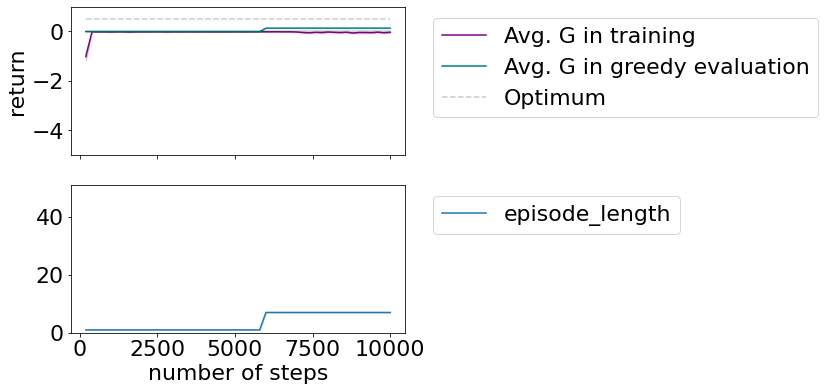

In [177]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

ax = axes[0]
x = list(metrics["training"].keys())
R = [v["return"] for v in metrics["training"].values()]
y = list(map(np.mean, R))
yCI = list(map(lambda p: bootstrap_empirical(p)(0.95), R))
Y = np.transpose(yCI)
ax.fill_between(x, Y[0,:], Y[1,:], color='purple', alpha=.2)
ax.plot(x, y, color='purple', label="Avg. G in training")


R = [v["return"] for v in metrics["evaluation"].values()]
y = list(map(np.mean, R))
yCI = list(map(lambda p: bootstrap_empirical(p)(0.95), R))
Y = np.transpose(yCI)
ax.fill_between(x, Y[0,:], Y[1,:], color='teal', alpha=.2)
ax.plot(x, y, color="teal", label="Avg. G in greedy evaluation")

ax.plot([x[0], x[-1]], [0, 0], 'k', alpha=0.2)
ax.plot([x[0], x[-1]], np.array([1, 1])*MAX_RETURN, 'k--', alpha=0.2, label="Optimum")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylabel("return")
ax.set_ylim(-5, 1)

ax = axes[1]
ax.set_xlabel("number of steps")

R = [v["episode_length"] for v in metrics["evaluation"].values()]
y = [np.mean(r) for r in R]
yCI = list(map(lambda p: bootstrap_empirical(p)(0.95), R))
Y = np.transpose(yCI)
ax.fill_between(x, Y[0,:], Y[1,:], color='teal', alpha=.2)

ax.plot(x, y, label="episode_length")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, EVALUATION_EPISODE_TIMEOUT+1)


# list(map(np.var, R))
plt.savefig(f"{FILE_SIG}.pdf", 
               bbox_inches='tight', 
               pad_inches=0)
pass

## Visualize trajectory

In [178]:
from matplotlib import animation, rc
from IPython.display import HTML

T, G = evaluate(ag, env, 1, greedy=True)
tau = T[0]
def animate_trajectory(tau):
    fig = plt.figure(figsize=env.size)
    plt.axis('off')
    ims = []
    for i in range(len(tau)):
        s, a, r, ns, T = tau[i]
        im = plt.imshow(env.encode_board(s), animated=True, origin='lower')
        ims.append([im])
        if T:
            im = plt.imshow(env.encode_board(ns), animated=True, origin='lower')
            ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True, repeat_delay=1000)
    plt.close()

    return ani

ani = animate_trajectory(tau)

# Show the animation
# HTML(ani.to_html5_video())
# HTML(ani.to_jshtml())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Michael Kaisers'), bitrate=1800)
ani.save(f"{FILE_SIG}-Tau.mp4", writer=writer)

In [179]:
# Visualise Q-learning
from mpl_toolkits.axes_grid1 import make_axes_locatable

# VISUALISE_METRIC = "N"
VISUALISE_METRIC = "V"
# VISUALISE_METRIC = "AD"

ann_list = []

width, height = env.size
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)

div = make_axes_locatable(ax)
cax = div.append_axes("right", size="5%", pad="3%")

ax.axis('off')
ims = []
Qs = list(metrics["training"].values())

tx = ax.set_title('')
plt.tight_layout()
fig.subplots_adjust(right=.8)

def animate(i):
    im = ax.imshow(Qs[i][VISUALISE_METRIC], animated=True, origin='lower')
    if VISUALISE_METRIC == "V":
        overlay_actions(Qs[i]['A'])
    cax.cla()
    cb = fig.colorbar(im, cax=cax)
    tx.set_text(f'{VISUALISE_METRIC} at {Qs[i]["t"]/n_steps*100:2.0f}% training')

ani = animation.FuncAnimation(fig, animate, frames=len(Qs))

plt.close()

# HTML(ani.to_jshtml())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Michael Kaisers'), bitrate=1800)
ani.save(f"{FILE_SIG}-QL-{VISUALISE_METRIC}.mp4", writer=writer)

In [180]:
Qs[-1]["AD"]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,        nan],
       [1.03929694, 1.05180013, 1.05722167, 1.059839  , 1.06995863,
        1.09654275, 1.14660293, 0.        ],
       [0.        , 0.        , 0.        , 0.        ,        nan,
               nan,        nan,        nan]])

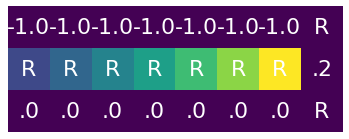

In [183]:
# Plot final values

# list(ag.Qe.Q[0])
# list(ag.Qe.Q.keys())
# for k,v in ag.Qe.Q.items():
#     print(f"{k} : {v}")

imV, imA = value_action_images(ag.Qe)
fig, ax = plt.subplots()
im = ax.imshow(imV, origin='lower')

ann_list = []
overlay_actions(imA)

plt.axis('off')
# plt.title("Values, Actions, Rewards")
fig.savefig(f"{FILE_SIG}_Values.pdf", 
               bbox_inches='tight', 
               pad_inches=0)